# Fake Account Detection

Made by:
- Francesco Pizzolato
- Tommaso Danieli




# Section 0: Data Frame Creation

In [ ]:
import pandas as pd
import os

def import_data():
    # Percorsi ai file JSON
    base_paths = [
        "data/automated-v1.0",
        "data/fake-v1.0"
    ]

    files = {
        "automated": "automatedAccountData.json",
        "nonautomated": "nonautomatedAccountData.json",
        "fake": "fakeAccountData.json",
        "real": "realAccountData.json"
    }

    # Costruisci i percorsi completi
    paths = {
        "automated": os.path.join(base_paths[0], files["automated"]),
        "nonautomated": os.path.join(base_paths[0], files["nonautomated"]),
        "fake": os.path.join(base_paths[1], files["fake"]),
        "real": os.path.join(base_paths[1], files["real"]),
    }

    # Leggi i file JSON come DataFrame
    df_automated = pd.read_json(paths["automated"])
    df_nonautomated = pd.read_json(paths["nonautomated"])
    df_fake = pd.read_json(paths["fake"])
    df_real = pd.read_json(paths["real"])

    # Unisci tutti i DataFrame in uno solo
    df_automated = pd.concat([df_automated, df_nonautomated], ignore_index=True)
    df_fake = pd.concat([df_fake, df_real], ignore_index=True)

    
    return df_automated, df_fake

In [33]:
df_automated, df_fake = import_data()

print("Number of automated accounts:", len(df_automated))
print("Number of fake accounts:", len(df_fake))

Number of automated accounts: 1400
Number of fake accounts: 1194


# Section 1: Fake Account Detection

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# y = colonna target
y = df_fake["isFake"]

# X = tutte le colonne tranne 'isFake'
X = df_fake.drop("isFake", axis=1)

print("===Feature sample===")
print(X[0:5])

print("\n===Target sample===")
print(y[0:5])


===Feature sample===
   userFollowerCount  userFollowingCount  userBiographyLength  userMediaCount  \
0                 25                1937                    0               0   
1                324                4122                    0               0   
2                 15                 399                    0               0   
3                 14                 107                    0               1   
4                264                4651                    0               0   

   userHasProfilPic  userIsPrivate  usernameDigitCount  usernameLength  
0                 1              1                   0              10  
1                 1              0                   4              15  
2                 0              0                   3              12  
3                 1              0                   1              10  
4                 1              0                   0              14  

===Target sample===
0    1
1    1
2    1
3    1
4    

In [86]:
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE, ADASYN

# Suddividiamo in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2159407, shuffle=True)


# Applichiamo SMOTE solo al training set
bordersmote = SMOTENC(categorical_features=[4, 5],random_state=65)
X_train_res, y_train_res = bordersmote.fit_resample(X_train, y_train)

--------------
## 1.1 RandomForest implementation

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report


# Definizione del modello base
rf = RandomForestClassifier(random_state=2159407)

# Definizione della griglia dei parametri da ottimizzare
param_grid = {
    "n_estimators": [309, 310, 311, 312, 313, 314, 315],           # numero di alberi
    "max_depth": [ 8, 9, 10],           # profondità massima degli alberi
    "min_samples_split": [2],           # minimo numero di campioni per split
    "min_samples_leaf": [2],             # minimo numero di campioni per foglia
    "max_features": ["sqrt", "log2", None],   # numero di feature da considerare per split
    "bootstrap": [True, False]
}

# GridSearch con 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=10,                # 5-fold validation
    n_jobs=-1,           # usa tutti i core disponibili
    verbose=1,
    scoring='f1_macro'   # possiamo usare anche 'f1' se il dataset è sbilanciato
)

# Fit del GridSearch sui dati di training
grid_search.fit(X_train_res, y_train_res)

# Parametri ottimali
print("Best parameters found:", grid_search.best_params_)

# Miglior modello
best_rf = grid_search.best_estimator_

# Valutazione sul test set
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Set: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Real", "Fake"]))

Fitting 10 folds for each of 126 candidates, totalling 1260 fits
Best parameters found: {'bootstrap': True, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 309}
Accuratezza sul test set: 0.97
Report completo:
              precision    recall  f1-score   support

        Real       0.98      0.98      0.98       192
        Fake       0.93      0.91      0.92        47

    accuracy                           0.97       239
   macro avg       0.96      0.95      0.95       239
weighted avg       0.97      0.97      0.97       239



------------------------------------------------------------------------------------------------------------------------------------
## 1.2 CatBoost implementation

In [1]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist_cat = {
    'iterations': randint(300, 400),
    'depth': randint(5, 12),
    'learning_rate': uniform(0.05, 0.13),
    'l2_leaf_reg': uniform(6, 8),
    'bagging_temperature': uniform(0, 0.08)
}

cat = CatBoostClassifier(
    random_state=2159407,
    eval_metric='TotalF1',
    verbose=0
)

search_cat = RandomizedSearchCV(
    cat,
    param_distributions=param_dist_cat,
    n_iter=500,
    scoring='f1_macro',
    n_jobs=-1,
    cv=5,
    verbose=1,
    random_state=987
)

search_cat.fit(X_train_res, y_train_res)
print("Best params (CatBoost):", search_cat.best_params_)

NameError: name 'X_train_res' is not defined


Classification Report:
              precision    recall  f1-score   support

           0      0.964     0.990     0.977       192
           1      0.952     0.851     0.899        47

    accuracy                          0.962       239
   macro avg      0.958     0.920     0.938       239
weighted avg      0.962     0.962     0.962       239


Confusion Matrix:
 [[190   2]
 [  7  40]]
ROC AUC: 0.9941267730496455


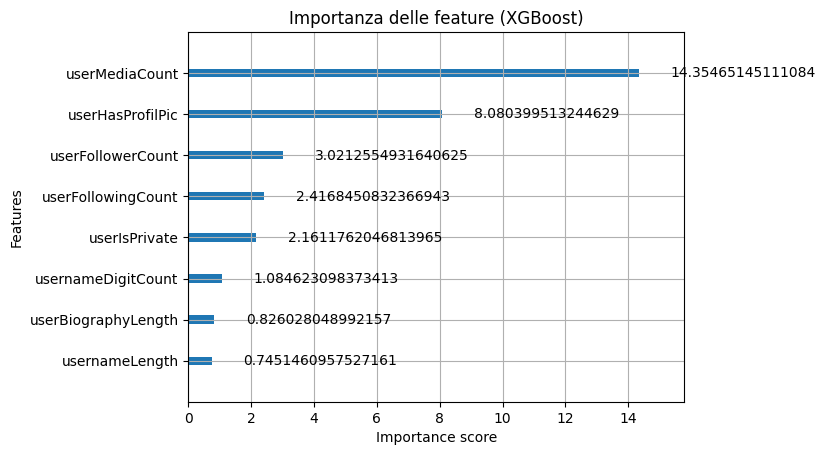

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
import numpy as np
import pandas as pd


# Miglior modello CatBoost trovato dal RandomizedSearchCV
best_cat = search_cat.best_estimator_

# Predizioni
y_pred = best_cat.predict(X_test)
y_proba = best_cat.predict_proba(X_test)[:, 1] if len(np.unique(y_test)) == 2 else None

# Metriche
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print("=== Risultati CatBoost ===")
print(f"Accuracy:      {acc:.4f}")
print(f"F1 (macro):    {f1:.4f}")

if y_proba is not None:
    auc = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC:       {auc:.4f}")

# Report dettagliato
print("\nClassification report:")
print(classification_report(y_test, y_pred))

# Matrice di confusione
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=np.unique(y_test), columns=np.unique(y_test))
print("\nConfusion matrix:")
print(cm_df)

## Section 2: Automated Account Detection